In [200]:
##House Prices: Advanced Regression Techniques Test 
##Author: Nok Chan 
##Last modified: 8/13/2017

![Kaggle House Price Competition](HousePrice.png)

![Rank](rank1.png)

![Total Participant](rank2.png)

In [201]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import ensemble, tree, linear_model
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
#pd.DataFrame(result_pd_RF).to_csv('resultRF.csv',index = False)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import os
%matplotlib inline 
#This line force the graph print out in this jupyter Notebook

In [202]:
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

In [203]:

testset = pd.read_csv('test.csv')
trainset = pd.read_csv('train.csv')

In [204]:
trainset.isnull().sum()
## Some features have almost all null in every rows, so I will remove null> 1000 for cleaning the features a little bit.


Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [205]:
features = trainset.columns.values
remove_features = trainset.columns[trainset.isnull().sum()>1000]


In [206]:
print(testset.shape)
print(trainset.shape)

(1459, 80)
(1460, 81)


In [207]:
trainset = trainset.drop(remove_features,1)
trainset = trainset.drop('Id', 1)


In [208]:
testset = testset.drop(remove_features,1)
testset_id = testset['Id']
testset = testset.drop('Id', 1)

In [209]:
remove_features

Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [210]:
print(testset.shape)
print(trainset.shape)

(1459, 75)
(1460, 76)


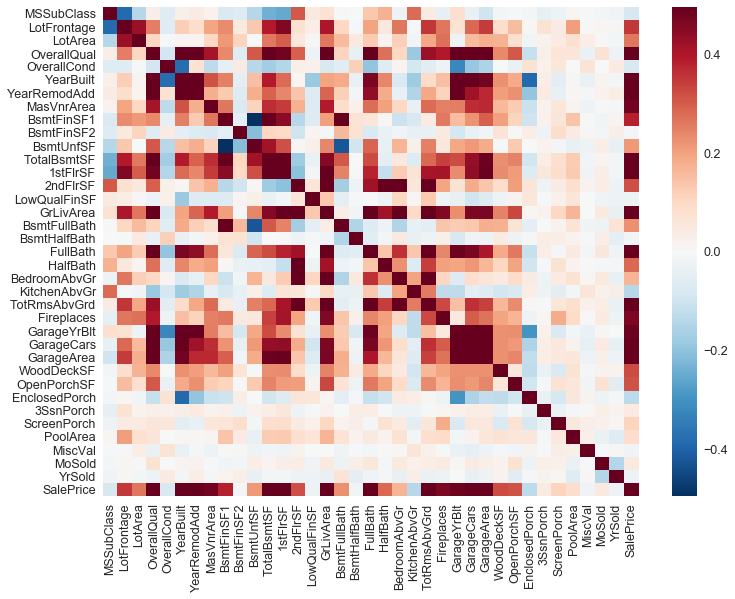

In [211]:
## For now, i will start with the numerical variable and ignore the categorial variables for a while
## Start with correlation always give you some insights about how different factor related.
## Since the number of variables is large, it's not easy to visualize with table, a matrix could help us on this.
## Seaborn library-
train_cor = trainset.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(train_cor,vmax=0.1)

In [212]:
## From the heatmap we can see some variable has correlation very close to 0.8
## Grage YrBlt,GarageCars,Garage Area are strongly correlated, we don't want this collinearity as Area of Garage 
##is limiting factor of how many car u can park.

## TotalBsmtSF and ,1stFlrSF  is also highly correlated, see the metadata.
##     1stFlrSF: First Floor square feet
## TotalBsmtSF: Total square feet of basement area

## YearBLT is also highly correlated to GarageYearBLT
## OverallQuality has a strong correlation with Sales Price too, this is good as this is a useful indicator for predicting 
## sales price which is our ultimate goal.



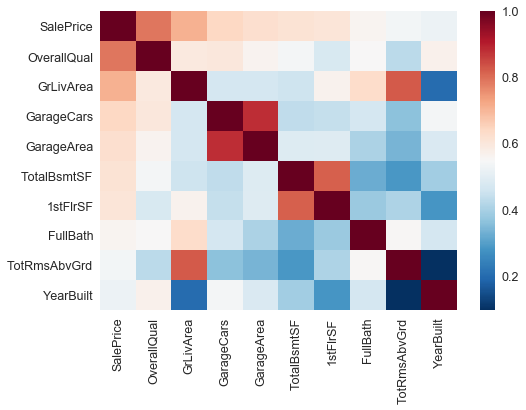

In [213]:
## To decide which factor we should keep, I will keep the factor that are more correlated to sales price as I think this
## will help the performence of the model.

#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = train_cor.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(trainset[cols].values.T)
sns.set(font_scale=1.25)


hm = sns.heatmap(cm,cmap="RdBu_r", yticklabels=cols.values, xticklabels=cols.values)

## The order of the features is already sorted in descending order.




In [214]:
## GarageCars has a higher correlation, so Garage Area and GarageYearBlt will be dropped.
## TotalBsmtSF has a higher correlation with 1stFlrSF, so it will be dropped as well.
trainset = trainset.drop(['1stFlrSF','GarageArea','GarageYrBlt'],1)
testset = testset.drop(['1stFlrSF','GarageArea','GarageYrBlt'],1)

In [215]:
print(trainset.shape)
print(testset.shape)
## Ok , 3 mores columns dropped

(1460, 73)
(1459, 72)


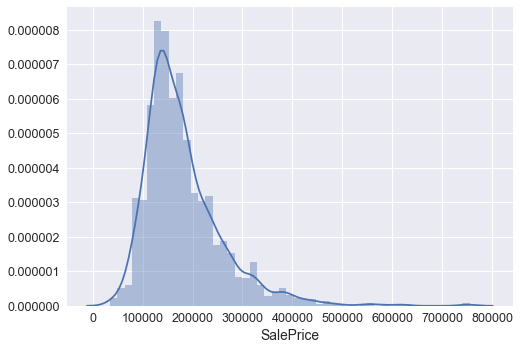

In [216]:
## So some more EPA about our target variable -- Sales Price

sns.distplot(trainset['SalePrice'])


## The data looks quite good, money is always appear in a skewed distribution in normal scale, we can normalized it in a log scale.


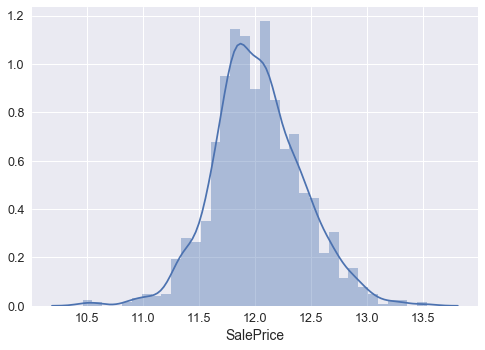

In [217]:
sns.distplot(np.log(trainset['SalePrice']))

## Voila, it is very close to normal distrubtion.
## Therefore, it is good to apply log transformation to SalePrice variable as regression usually need a normal distribution error assumption

trainset['SalePrice'] =np.log(trainset['SalePrice'])

In [218]:
train_labels=trainset['SalePrice']
trainset=trainset.drop('SalePrice',1)

In [219]:
print(trainset.shape)
print(testset.shape)
## Ok , 3 mores columns dropped

(1460, 72)
(1459, 72)


In [220]:
trainset_index = range(len(trainset))
testset_index = range(len(trainset),len(trainset) + len(testset))

In [221]:
from sklearn.model_selection import train_test_split
trainset_index_backup = trainset_index

trainset_index, validset_index = train_test_split(trainset_index,
                                    random_state = 42 , test_size = 0.3)


In [222]:
print(len(trainset_index), len(validset_index))

1022 438


In [223]:
masterset = pd.concat([trainset,testset], axis = 0)

In [224]:
masterset.shape

(2919, 72)

In [225]:
masterset_backup = masterset
# Getting Dummies from all other categorical vars
for col in masterset.dtypes[masterset.dtypes == 'object'].index:
    for_dummy = masterset.pop(col)
    masterset = pd.concat([masterset, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [226]:
masterset.shape

(2919, 272)

In [227]:
train_features = masterset.iloc[trainset_index] 
test_features = masterset.iloc[testset_index]
train_labels, valid_labels = train_labels[trainset_index],train_labels[validset_index]

In [104]:
print(train_features.shape)
print(test_features.shape)

(1022, 272)
(1459, 272)


## Gradient Boosting

## On Hold

In [230]:
## Custom Scorer match with Kaggle Evaluation
from sklearn.metrics import make_scorer

def kaggle_score(y, yhat):
    temp = 0
    for i in range(len(y)):
       temp = temp + (np.log(y[i])-np.log(yhat[i]))**2
    return np.sqrt(temp/(len(y)))

kaggle_scorer =  make_scorer(kaggle_score,greater_is_better = False)

In [197]:
## Model
GBest = ensemble.GradientBoostingRegressor( max_features='sqrt',
                                           min_samples_leaf=15, min_samples_split=10,
                                           loss='huber',
                                           random_state = 42)
PipeGB = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
        ('selection', SelectKBest()),
        ('pca', PCA()),
        ('boost', GBest)
    ])
# estimator parameters
kfeatures = [32,64,128,256]
components = [4,8,16,32]
estimators = [256,512,1024]
learnrate = [0.001,0.01,0.1,1]
depth = [3,6,9]

param_grid_GB={'selection__k': kfeatures,
              'pca__n_components': components,
              'imp__strategy': ['mean','median'],
                'imp__missing_values': ['NaN'],
              'boost__n_estimators': estimators,
              'boost__learning_rate':  learnrate,
            'boost__max_depth' : depth
               }

In [231]:
# set model parameters to grid search object
gridCV_GB = RandomizedSearchCV(estimator = PipeGB, 
                             param_distributions = param_grid_GB,
                             n_iter = 5,
                             scoring = 'neg_mean_squared_log_error',
                             cv = 5)

        
# train the model
gridCV_GB.fit(train_features, train_labels)

print(gridCV_GB.best_params_)
print(gridCV_GB.cv_results_)

C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 95  98  99 121 134 151 169 183 201 210 217 259 264] are constant.
  UserWarning)
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 48  49  95  97  98  99 118 119 121 122 134 151 169 183 201 204 217 228
 259 261] are constant.
  UserWarning)
C:\Users\noklam.chan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\uni

KeyboardInterrupt: 

In [229]:
print(train_features.shape)
print(train_labels.shape)

(1022, 272)
(1022,)


In [145]:
gridCV_GB.best_params_

{'boost__learning_rate': 0.01,
 'boost__max_depth': 6,
 'boost__n_estimators': 1024,
 'imp__missing_values': 'NaN',
 'imp__strategy': 'mean',
 'pca__n_components': 32,
 'selection__k': 32}

In [146]:
1-(-gridCV_GB.best_score_)**0.5

0.98588636648660133

In [147]:
##import pickle
# Save the model if rerun above cell for searching hyperparameters
with open('model_GB.pkl', 'wb') as source:    
  s = pickle.dump(gridCV_GB.best_estimator_, source)

In [148]:
with open('model_GB.pkl','rb') as load:
    model_GB = pickle.load(load)

In [152]:
model_GB.score(train_features, train_labels)

0.94974029965725926

In [ ]:
### Validation

In [ ]:
result_GB = model_GB.predict(test_features)

In [ ]:
## Output result, match the require format
result_pd= pd.DataFrame(np.array(list(zip(testset_index,result_GB))),
                        columns=['Id','SalePrice']) ## Id start from 1
result_pd.Id = result_pd.Id.astype('int') + 1 ## Id = index + 1
result_pd['SalePrice'] = result_pd['SalePrice'].apply(lambda x: np.e**(x))

In [ ]:
result_pd[0:5]

In [ ]:
pd.DataFrame(result_pd).to_csv('result.csv',index = False)

## Random Forest

In [ ]:
## RandomForest
from sklearn.ensemble import RandomForestRegressor
## Model
RF = RandomForestRegressor( max_features='sqrt'
                            ,n_jobs = 4, random_state = 42 )
PipeRF = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
          ('pca', PCA()),
        ('RF', RF)
    ])
# estimator parameters

components = [8,16,32,64]

minsamplessplit = [10,15,30]

minsamplessleaf = [2,4,6,8]

param_grid_RF={
              'pca__n_components': components,
              'imp__strategy': ['mean','median'],                         
            'RF__min_samples_leaf' : minsamplessleaf,
            'RF__min_samples_split' : minsamplessplit
               }

In [ ]:
# set model parameters to grid search object
gridCV_RF = GridSearchCV(estimator = PipeRF, 
                             param_grid = param_grid_RF,
                            
                             scoring = 'neg_mean_squared_log_error',
                             cv = 5)

        
# train the model
gridCV_RF.fit(train_features, train_labels)


print(gridCV_RF.best_params_)
print(gridCV_RF.cv_results_)

In [143]:
np.e**(-0.0003**0.5)

0.9828286296359545

In [144]:
import pickle
# Save the model if rerun above cell for searching hyperparameters
with open('model_RF.pkl', 'wb') as source:    
    s = pickle.dump(gridCV_RF.best_estimator_, source)
with open('model_RF.pkl','rb') as load:
    model_RF = pickle.load(load)

NameError: name 'gridCV_RF' is not defined

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(gridCV_RF.best_estimator_, train_features, train_labels,
                cv = 5, scoring = 'neg_mean_squared_log_error')

In [ ]:
## Output result, match the require format
result_RF = model_RF.predict(test_features)
result_pd_RF= pd.DataFrame(np.array(list(zip(testset_index,result_RF))),
                        columns=['Id','SalePrice']) ## Id start from 1
result_pd_RF.Id = result_pd_RF.Id.astype('int') + 1 ## Id = index + 1
result_pd_RF['SalePrice'] = result_pd_RF['SalePrice'].apply(lambda x: np.e**(x))

In [ ]:
pd.DataFrame(result_pd_RF).to_csv('resultRF.csv',index = False)

## Elastic Net

In [71]:
from sklearn import linear_model

In [249]:
## RandomForest
from sklearn.ensemble import RandomForestRegressor
## Model
EN = linear_model.ElasticNetCV(  random_state = 42 )
PipeEN = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
        ('EN', EN)
    ])
# estimator parameters

alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
l1_ratio = [0.0001, 0.001, 0.01, 0.1,0.5,1]

param_grid_EN={             
              'imp__strategy': ['mean','median'],                         
            'EN__alphas' :alphas, 
            'EN__l1_ratio' : l1_ratio
               }

In [254]:
train_features.shape
train_labels.shape

(1022,)

In [250]:
# set model parameters to grid search object
gridCV_EN = GridSearchCV(estimator = PipeEN, 
                             param_grid = param_grid_EN,                            
                             scoring = 'neg_mean_squared_log_error',
                             cv = 5)

        
# train the model
gridCV_EN.fit(train_features, train_labels)


print(gridCV_EN.best_params_)
print(gridCV_EN.cv_results_)

AxisError: axis -1 is out of bounds for array of dimension 0

In [ ]:
import pickle
# Save the model if rerun above cell for searching hyperparameters
with open('model_EN.pkl', 'wb') as source:    
    s = pickle.dump(gridCV_EN.best_estimator_, source)
with open('model_EN.pkl','rb') as load:
    model_EN = pickle.load(load)

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(gridCV_EN.best_estimator_, train_features, train_labels,
                cv = 5, scoring = 'neg_mean_squared_log_error')

In [ ]:
## Output result, match the require format
result_EN = model_EN.predict(test_features)
result_pd_EN= pd.DataFrame(np.array(list(zip(testset_index,result_EN))),
                        columns=['Id','SalePrice']) ## Id start from 1
result_pd_EN.Id = result_pd_EN.Id.astype('int') + 1 ## Id = index + 1
result_pd_EN['SalePrice'] = result_pd_EN['SalePrice'].apply(lambda x: np.e**(x))

In [ ]:
pd.DataFrame(result_pd_EN).to_csv('resultEN.csv',index = False)

In [ ]:
# ### Splitting with scikit.learn.train_test_split library
# x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.1, random_state=200)

In [ ]:
# ### Check score for validation test set
# print('Score of Gradienet Boosting Model: ',GBest.score(x_test,y_test))

In [ ]:
# from sklearn.model_selection import GridSearchCV
# ## class sklearn.model_selection.GridSearchCV(estimator, param_grid, scoring=None, 
# ## fit_params=None, n_jobs=1, iid=True,refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', 
# ## error_score='raise', return_train_score=True)